## Lybraries Import

In [92]:
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster.elbow import KElbowVisualizer
from sklearn.mixture import GaussianMixture
from IPython.display import YouTubeVideo
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import dendrogram

import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

## 1.Functions

In [93]:
def number_clusters(df,cluster_model):
    metrics=['silhouette','distortion','calinski_harabasz']
    model=cluster_model
    for score in metrics:
        plt.figure()
        plt.ylabel(score)
        plt.xlabel('Number of clusters')
        Visualizer=KElbowVisualizer(model,metric=score).fit(df)
        plt.show

In [94]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

In [95]:
def gmm_config(data,limit_nrcomponents):
    bic_values =[]
    aic_values =[]
    types_covariance=['full','diag','spherical']
    for i in types_covariance:
        n_components = np.arange(1, limit_nrcomponents)
        models = [GaussianMixture(n, covariance_type=i, n_init=10, random_state=1).fit(data)
                  for n in n_components]
        bic_values.append([m.bic(data) for m in models])
        aic_values.append([m.aic(data) for m in models])
    #barplot for BIC
    bic=plt.figure(1)
    X = np.arange(1,limit_nrcomponents)
    plt.bar(X + 0.00, bic_values[0], label='full' ,color = 'b', width = 0.3)
    plt.bar(X + 0.25, bic_values[1], label='diag',color = 'g', width = 0.3)
    plt.bar(X + 0.50, bic_values[2], label='spherical',color = 'r', width = 0.3)
    plt.xlabel('number of components')
    plt.ylabel('BIC')
    plt.legend(loc='best')
   #barplot for AIC
    aic=plt.figure(2)
    X = np.arange(1,limit_nrcomponents)
    plt.bar(X + 0.00, aic_values[0], label='full' ,color = 'b', width = 0.3)
    plt.bar(X + 0.25, aic_values[1], label='diag',color = 'g', width = 0.3)
    plt.bar(X + 0.50, aic_values[2], label='spherical',color = 'r', width = 0.3)
    plt.xlabel('number of components')
    plt.ylabel('AIC')
    plt.legend(loc='best')
    bic.show
    aic.show

In [96]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss  # return sum of sum of squares of each df variable
    
    sst = get_ss(df)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        hclabels = cluster.fit_predict(df) #get cluster labels
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  # concat df with labels
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
        ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
        r2.append(ssb / sst)  # save the R2 of the given cluster solution
        
    return np.array(r2)

In [97]:
#on 'type_covariance'-you have to insert with '', for example 'full'
def gmm_components(data,type_covariance,min_components,max_components):
    # Selecting number of components based on AIC and BIC
    n_components = np.arange(min_components,max_components)
    models = [GaussianMixture(n, covariance_type=type_covariance, n_init=10, random_state=1).fit(data)
              for n in n_components]

    bic_values = [m.bic(data) for m in models]
    aic_values = [m.aic(data) for m in models]
    plt.plot(n_components, bic_values, label='BIC')
    plt.plot(n_components, aic_values, label='AIC')
    plt.legend(loc='best')
    plt.xlabel('n_components')
    plt.xticks(n_components)
    plt.show()

# 2.Load the Dataset

In [98]:
normalized_df = pd.read_csv(r'C:\Users\gonca\Documents\BC1_GroupS\data\cleaneddata_02.csv') 
normalized_df

Dayswus       Age       Edu    Income      Freq   Recency       LTV  \
0    -0.386685  0.115790  0.551252  0.084099  0.128873 -0.315187  0.245044   
1     0.156308  0.343155  0.144543  0.276990  0.389456 -0.124698  0.242769   
2    -0.151430 -0.238120 -0.342623 -0.209300 -0.123218  0.013431 -0.100270   
3     0.170299 -0.091967 -0.100257 -0.080551 -0.253960 -0.042648 -0.174499   
4    -0.085694 -0.029673 -0.121884 -0.056412 -0.308742 -0.397524 -0.202662   
...        ...       ...       ...       ...       ...       ...       ...   
9567  0.366237  0.153253  0.551514  0.114085  0.102241  0.059961 -0.033271   
9568 -0.434316  0.293128 -0.283801  0.143237  0.068861 -0.062155  0.170344   
9569 -0.188526 -0.246703 -0.354973 -0.154329 -0.139088  0.049187 -0.098339   
9570  0.147930  0.136350 -0.163348  0.325560  0.308848 -0.263414  0.095482   
9571 -0.014429 -0.157318 -0.107477 -0.153980 -0.138354  0.872041 -0.090428   

       Perdeal    Dryred  Sweetred     Drywh   Sweetwh   Dessert    Exotic  \
0    -0.280078  0.216859 -0.120083 -0.066358 -0.204709 -0.254278 -0.285284   
1    -0.236567 -0.022881 -0.205752  0.307861 -0.173830 -0.113453 -0.213417   
2     0.269407 -0.271403  0.398772 -0.152883  0.453084  0.276804  0.256500   
3     0.321304  0.347085 -0.180853 -0.322071 -0.179285 -0.183778  0.545868   
4     0.036889  0.409776 -0.257984 -0.369330 -0.179867 -0.223421  0.206477   
...        ...       ...       ...       ...       ...       ...       ...   
9567 -0.107596  0.369514 -0.293754 -0.218168 -0.248179 -0.254399 -0.092632   
9568 -0.276390 -0.269954  0.206990  0.170061  0.129592  0.231444 -0.049289   
9569 -0.041140 -0.269310  0.320229 -0.201716  0.580836  0.306566  0.207966   
9570 -0.329809  0.190073  0.165111 -0.465200  0.218390 -0.190648 -0.267866   
9571  0.115307 -0.129085  0.118984 -0.024972  0.144323  0.195498  0.136806   

      WebPurchase  WebVisit  
0       -0.098759 -0.022023  
1       -0.261745 -0.110662  
2        0.129568  0.159453  
3        0.214083  0.180518  
4        0.320618  0.100053  
...           ...       ...  
9567    -0.253431 -0.157993  
9568    -0.371943 -0.391863  
9569     0.119527 -0.009434  
9570    -0.156738 -0.025933  
9571     0.102772  0.070949  

[9572 rows x 16 columns]

In [99]:
perspective = normalized_df
perspective.head()

Dayswus       Age       Edu    Income      Freq   Recency       LTV  \
0 -0.386685  0.115790  0.551252  0.084099  0.128873 -0.315187  0.245044   
1  0.156308  0.343155  0.144543  0.276990  0.389456 -0.124698  0.242769   
2 -0.151430 -0.238120 -0.342623 -0.209300 -0.123218  0.013431 -0.100270   
3  0.170299 -0.091967 -0.100257 -0.080551 -0.253960 -0.042648 -0.174499   
4 -0.085694 -0.029673 -0.121884 -0.056412 -0.308742 -0.397524 -0.202662   

    Perdeal    Dryred  Sweetred     Drywh   Sweetwh   Dessert    Exotic  \
0 -0.280078  0.216859 -0.120083 -0.066358 -0.204709 -0.254278 -0.285284   
1 -0.236567 -0.022881 -0.205752  0.307861 -0.173830 -0.113453 -0.213417   
2  0.269407 -0.271403  0.398772 -0.152883  0.453084  0.276804  0.256500   
3  0.321304  0.347085 -0.180853 -0.322071 -0.179285 -0.183778  0.545868   
4  0.036889  0.409776 -0.257984 -0.369330 -0.179867 -0.223421  0.206477   

   WebPurchase  WebVisit  
0    -0.098759 -0.022023  
1    -0.261745 -0.110662  
2     0.129568  0.159453  
3     0.214083  0.180518  
4     0.320618  0.100053

# 3. Data preapration

In [79]:
#colocar aqui o codigo usado na preparação antes disso usar sem esta parte

# 4 - Clustering 

## 4.1- KMeans

### 4.1.2- K-Elbow plots

C:\Users\gonca\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\gonca\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\gonca\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\gonca\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, Yellowbrick

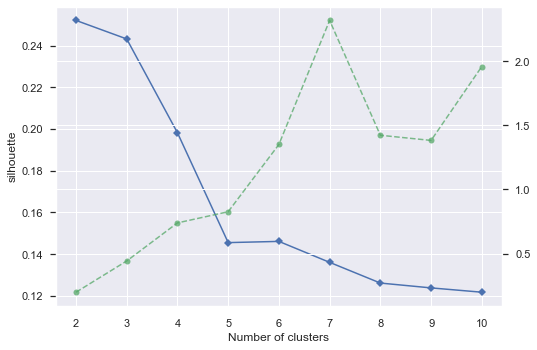

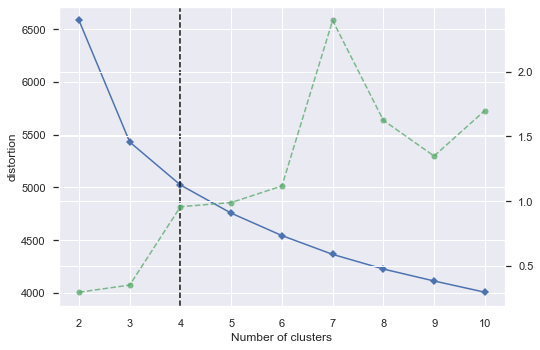

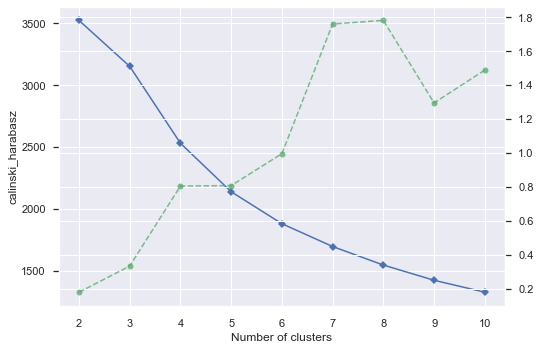

In [100]:
number_clusters(perspective,KMeans( init='k-means++', n_init=15, random_state=1))

### 4.1.2- Silhouette Analysis

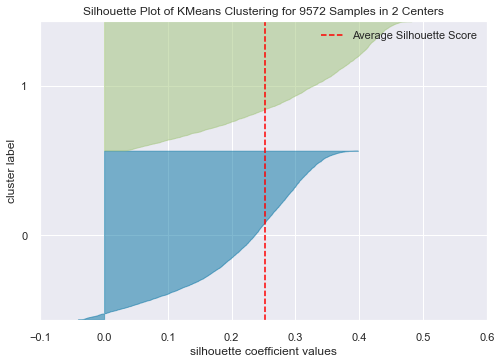

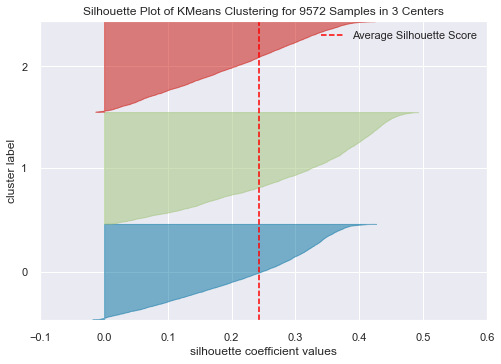

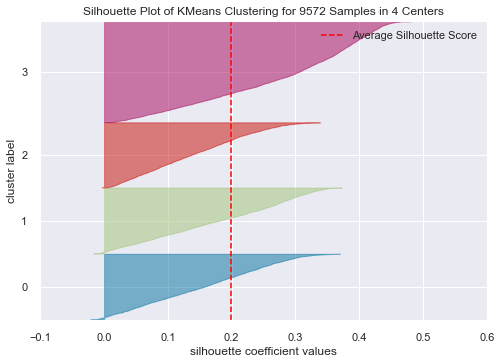

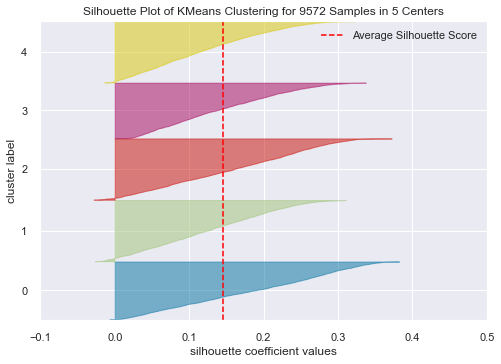

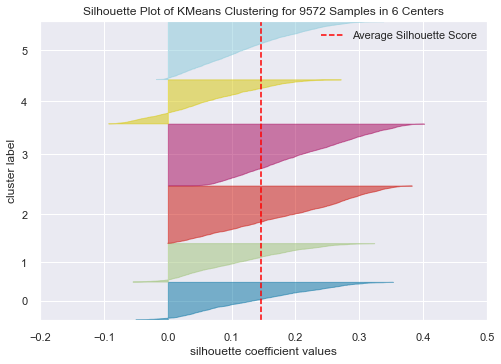

In [101]:
[SilhouetteVisualizer(KMeans(n_clusters=i,init='k-means++', n_init=15, random_state=1), colors='yellowbrick').fit(perspective).show() for i in range(2,7)]

### 4.1.3- Applying the clustering

In [102]:
#According to the KElbowVisualizer and the SilhouetteVisualizer we were able to determine that the optimal number of clusters is 5.
#confirmar nº de k
kmclust = KMeans(n_clusters=4, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(perspective)
df_concat = pd.concat((perspective, pd.Series(km_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

Dayswus       Age       Edu    Income      Freq   Recency       LTV  \
labels                                                                         
0       0.005815  0.061013  0.125541  0.060034  0.006456 -0.018728 -0.062786   
1      -0.012624 -0.224277 -0.164038 -0.211841 -0.179950  0.006207 -0.153400   
2       0.020491 -0.205798  0.092253 -0.202004 -0.230153  0.009894 -0.218116   
3      -0.013677  0.254620  0.000649  0.241335  0.230342 -0.017442  0.218947   

         Perdeal    Dryred  Sweetred     Drywh   Sweetwh   Dessert    Exotic  \
labels                                                                         
0      -0.099956  0.364646 -0.200682 -0.319886 -0.202386 -0.203263 -0.110495   
1       0.137653 -0.221268  0.187270  0.079786  0.185599  0.195418  0.182295   
2       0.288809  0.103298 -0.131957  0.031431 -0.125435 -0.127402  0.013236   
3      -0.228445 -0.059785  0.014177  0.087205  0.013088  0.011633 -0.112272   

        WebPurchase  WebVisit  
labels                         
0          0.070589  0.089254  
1          0.135759  0.103557  
2          0.211968  0.196703  
3         -0.254744 -0.234658

In [103]:
#Making a copy of the dataset and appending a column with the cluster assigned to the observation.
km_perspective = perspective.copy()
km_perspective["km_labels"] = km_labels
km_perspective

Dayswus       Age       Edu    Income      Freq   Recency       LTV  \
0    -0.386685  0.115790  0.551252  0.084099  0.128873 -0.315187  0.245044   
1     0.156308  0.343155  0.144543  0.276990  0.389456 -0.124698  0.242769   
2    -0.151430 -0.238120 -0.342623 -0.209300 -0.123218  0.013431 -0.100270   
3     0.170299 -0.091967 -0.100257 -0.080551 -0.253960 -0.042648 -0.174499   
4    -0.085694 -0.029673 -0.121884 -0.056412 -0.308742 -0.397524 -0.202662   
...        ...       ...       ...       ...       ...       ...       ...   
9567  0.366237  0.153253  0.551514  0.114085  0.102241  0.059961 -0.033271   
9568 -0.434316  0.293128 -0.283801  0.143237  0.068861 -0.062155  0.170344   
9569 -0.188526 -0.246703 -0.354973 -0.154329 -0.139088  0.049187 -0.098339   
9570  0.147930  0.136350 -0.163348  0.325560  0.308848 -0.263414  0.095482   
9571 -0.014429 -0.157318 -0.107477 -0.153980 -0.138354  0.872041 -0.090428   

       Perdeal    Dryred  Sweetred     Drywh   Sweetwh   Dessert    Exotic  \
0    -0.280078  0.216859 -0.120083 -0.066358 -0.204709 -0.254278 -0.285284   
1    -0.236567 -0.022881 -0.205752  0.307861 -0.173830 -0.113453 -0.213417   
2     0.269407 -0.271403  0.398772 -0.152883  0.453084  0.276804  0.256500   
3     0.321304  0.347085 -0.180853 -0.322071 -0.179285 -0.183778  0.545868   
4     0.036889  0.409776 -0.257984 -0.369330 -0.179867 -0.223421  0.206477   
...        ...       ...       ...       ...       ...       ...       ...   
9567 -0.107596  0.369514 -0.293754 -0.218168 -0.248179 -0.254399 -0.092632   
9568 -0.276390 -0.269954  0.206990  0.170061  0.129592  0.231444 -0.049289   
9569 -0.041140 -0.269310  0.320229 -0.201716  0.580836  0.306566  0.207966   
9570 -0.329809  0.190073  0.165111 -0.465200  0.218390 -0.190648 -0.267866   
9571  0.115307 -0.129085  0.118984 -0.024972  0.144323  0.195498  0.136806   

      WebPurchase  WebVisit  km_labels  
0       -0.098759 -0.022023          0  
1       -0.261745 -0.110662          3  
2        0.129568  0.159453          1  
3        0.214083  0.180518          2  
4        0.320618  0.100053          0  
...           ...       ...        ...  
9567    -0.253431 -0.157993          0  
9568    -0.371943 -0.391863          3  
9569     0.119527 -0.009434          1  
9570    -0.156738 -0.025933          3  
9571     0.102772  0.070949          1  

[9572 rows x 17 columns]

### 4.1.4- Cluster Profile

TypeError: annotate() missing 1 required positional argument: 's'

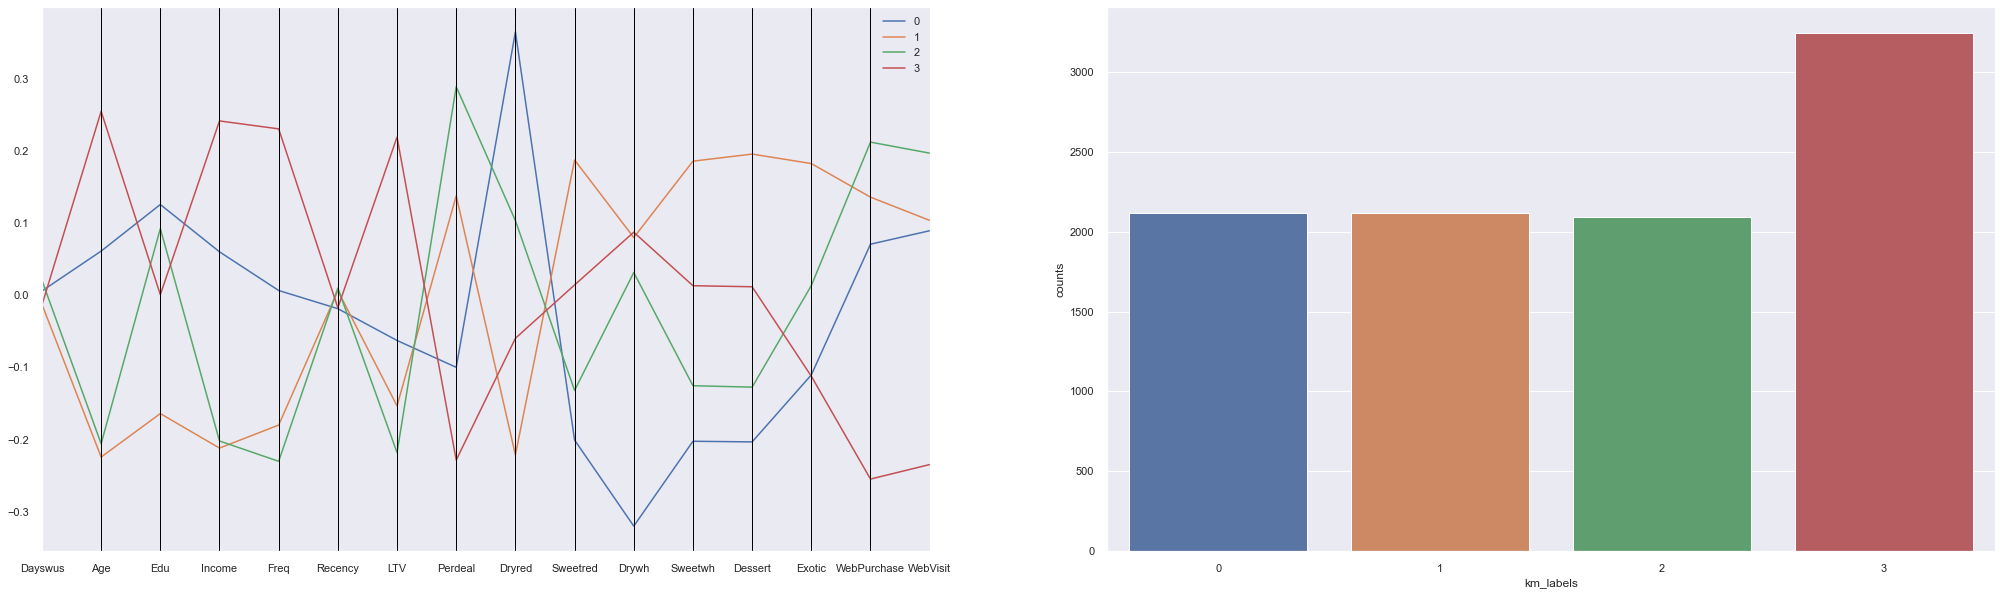

In [104]:
cluster_profiles(km_perspective, ["km_labels"],(35,10), compar_titles=None)

## 4.2- GMM
### 4.2.1 Choosing the type of covariance

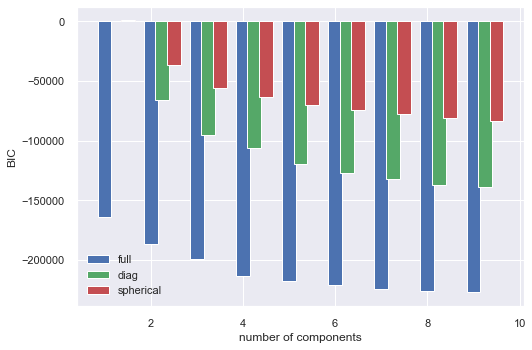

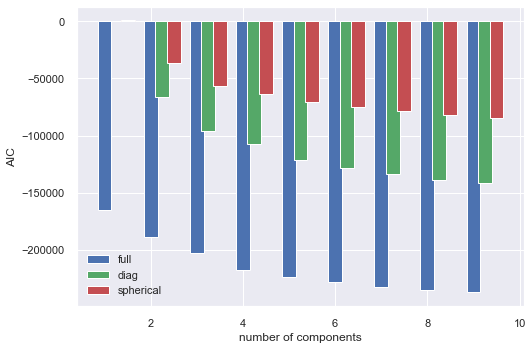

In [105]:
gmm_config(perspective,10)

In [106]:
#For the most part, the number of components the model with the lowest AIC and BIC is 'full' 

### 4.2.2- Find the number of components

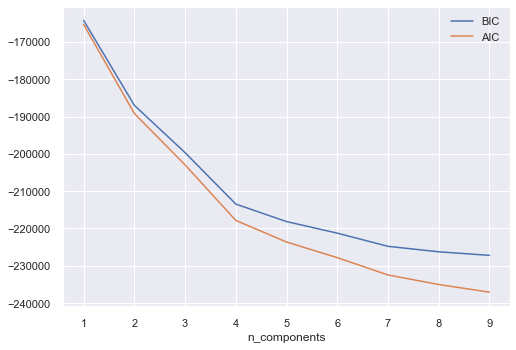

In [107]:
gmm_components(perspective,'full',1,10) #escolher tipo onde esta 'full'

In [17]:
#According to the graph, the teams considers the optimal number of components is 4.

### 4.2.3- Applying the clustering

In [108]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(perspective)
# Concatenating the labels to df
df_concat = pd.concat([perspective, pd.Series(gmm_labels, index=perspective.index, name="gmm_labels")], axis=1)
df_concat.head()

Dayswus       Age       Edu    Income      Freq   Recency       LTV  \
0 -0.386685  0.115790  0.551252  0.084099  0.128873 -0.315187  0.245044   
1  0.156308  0.343155  0.144543  0.276990  0.389456 -0.124698  0.242769   
2 -0.151430 -0.238120 -0.342623 -0.209300 -0.123218  0.013431 -0.100270   
3  0.170299 -0.091967 -0.100257 -0.080551 -0.253960 -0.042648 -0.174499   
4 -0.085694 -0.029673 -0.121884 -0.056412 -0.308742 -0.397524 -0.202662   

    Perdeal    Dryred  Sweetred     Drywh   Sweetwh   Dessert    Exotic  \
0 -0.280078  0.216859 -0.120083 -0.066358 -0.204709 -0.254278 -0.285284   
1 -0.236567 -0.022881 -0.205752  0.307861 -0.173830 -0.113453 -0.213417   
2  0.269407 -0.271403  0.398772 -0.152883  0.453084  0.276804  0.256500   
3  0.321304  0.347085 -0.180853 -0.322071 -0.179285 -0.183778  0.545868   
4  0.036889  0.409776 -0.257984 -0.369330 -0.179867 -0.223421  0.206477   

   WebPurchase  WebVisit  gmm_labels  
0    -0.098759 -0.022023           3  
1    -0.261745 -0.110662           0  
2     0.129568  0.159453           2  
3     0.214083  0.180518           1  
4     0.320618  0.100053           1

In [109]:
gmm_perspective = perspective.copy()
gmm_perspective["gmm_labels"] = gmm_labels
gmm_perspective

Dayswus       Age       Edu    Income      Freq   Recency       LTV  \
0    -0.386685  0.115790  0.551252  0.084099  0.128873 -0.315187  0.245044   
1     0.156308  0.343155  0.144543  0.276990  0.389456 -0.124698  0.242769   
2    -0.151430 -0.238120 -0.342623 -0.209300 -0.123218  0.013431 -0.100270   
3     0.170299 -0.091967 -0.100257 -0.080551 -0.253960 -0.042648 -0.174499   
4    -0.085694 -0.029673 -0.121884 -0.056412 -0.308742 -0.397524 -0.202662   
...        ...       ...       ...       ...       ...       ...       ...   
9567  0.366237  0.153253  0.551514  0.114085  0.102241  0.059961 -0.033271   
9568 -0.434316  0.293128 -0.283801  0.143237  0.068861 -0.062155  0.170344   
9569 -0.188526 -0.246703 -0.354973 -0.154329 -0.139088  0.049187 -0.098339   
9570  0.147930  0.136350 -0.163348  0.325560  0.308848 -0.263414  0.095482   
9571 -0.014429 -0.157318 -0.107477 -0.153980 -0.138354  0.872041 -0.090428   

       Perdeal    Dryred  Sweetred     Drywh   Sweetwh   Dessert    Exotic  \
0    -0.280078  0.216859 -0.120083 -0.066358 -0.204709 -0.254278 -0.285284   
1    -0.236567 -0.022881 -0.205752  0.307861 -0.173830 -0.113453 -0.213417   
2     0.269407 -0.271403  0.398772 -0.152883  0.453084  0.276804  0.256500   
3     0.321304  0.347085 -0.180853 -0.322071 -0.179285 -0.183778  0.545868   
4     0.036889  0.409776 -0.257984 -0.369330 -0.179867 -0.223421  0.206477   
...        ...       ...       ...       ...       ...       ...       ...   
9567 -0.107596  0.369514 -0.293754 -0.218168 -0.248179 -0.254399 -0.092632   
9568 -0.276390 -0.269954  0.206990  0.170061  0.129592  0.231444 -0.049289   
9569 -0.041140 -0.269310  0.320229 -0.201716  0.580836  0.306566  0.207966   
9570 -0.329809  0.190073  0.165111 -0.465200  0.218390 -0.190648 -0.267866   
9571  0.115307 -0.129085  0.118984 -0.024972  0.144323  0.195498  0.136806   

      WebPurchase  WebVisit  gmm_labels  
0       -0.098759 -0.022023           3  
1       -0.261745 -0.110662           0  
2        0.129568  0.159453           2  
3        0.214083  0.180518           1  
4        0.320618  0.100053           1  
...           ...       ...         ...  
9567    -0.253431 -0.157993           1  
9568    -0.371943 -0.391863           0  
9569     0.119527 -0.009434           2  
9570    -0.156738 -0.025933           3  
9571     0.102772  0.070949           2  

[9572 rows x 17 columns]

### 4.2.4- Cluster Profilling

TypeError: annotate() missing 1 required positional argument: 's'

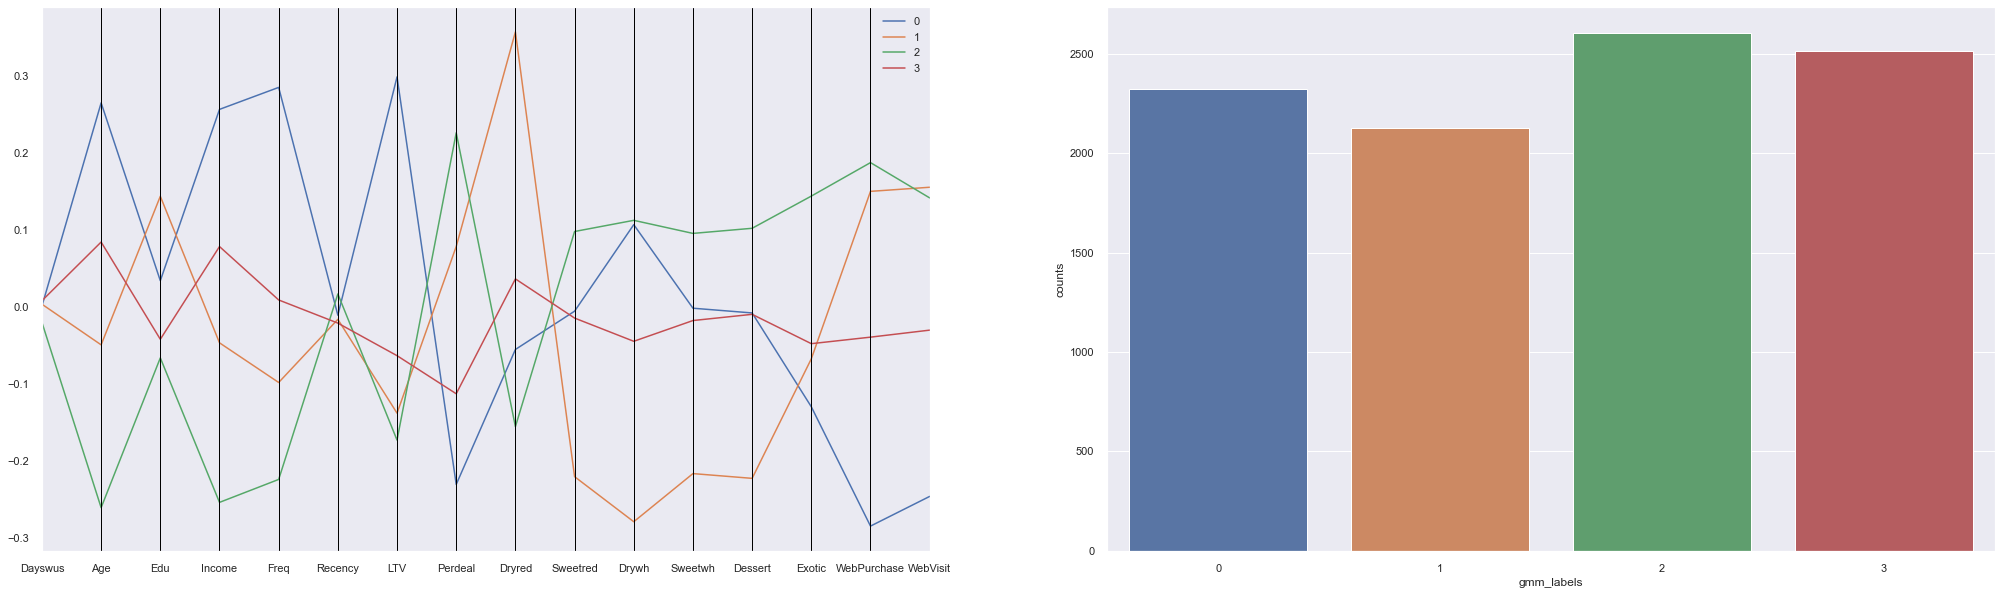

In [110]:
cluster_profiles(gmm_perspective, ["gmm_labels"], (35,10) , compar_titles=None)

## 4.3- K-means + SOM

In [111]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

# Notice that the SOM did not converge - We're under a time constraint for this class
sm = sompy.SOMFactory().build(
    perspective.values, 
    mapsize=(50, 50), 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    
)
sm.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.008000 seconds
 Rough training...
 radius_ini: 17.000000 , radius_final: 2.833333, trainlen: 100

 epoch: 1 ---> elapsed time:  0.523000, quantization error: 3.654167

 epoch: 2 ---> elapsed time:  0.525000, quantization error: 3.985913

 epoch: 3 ---> elapsed time:  0.535000, quantization error: 3.946739

 epoch: 4 ---> elapsed time:  0.528000, quantization error: 3.922813

 epoch: 5 ---> elapsed time:  0.581000, quantization error: 3.910285

 epoch: 6 ---> elapsed time:  0.549000, quantization error: 3.906156

 epoch: 7 ---> elapsed time:  0.589000, quantization error: 3.904157

 epoch: 8 ---> elapsed time:  0.575000, quantization error: 3.902369

 epoch: 9 ---> elapsed time:  0.505000, quantization error: 3.900602

 epoch: 10 ---> elapsed time:  0.531000, quantization error: 3.898801

 epoch: 11 ---> elapsed time:  0.547000, quantization error: 3.896876

 epoch: 12 ---> elapsed time:  0.559000, quantization error: 3.894640

 epoch: 13 --->

 epoch: 14 ---> elapsed time:  0.554000, quantization error: 2.875392

 epoch: 15 ---> elapsed time:  0.536000, quantization error: 2.866966

 epoch: 16 ---> elapsed time:  0.560000, quantization error: 2.858571

 epoch: 17 ---> elapsed time:  0.528000, quantization error: 2.850179

 epoch: 18 ---> elapsed time:  0.526000, quantization error: 2.841755

 epoch: 19 ---> elapsed time:  0.600000, quantization error: 2.833327

 epoch: 20 ---> elapsed time:  0.556000, quantization error: 2.824821

 epoch: 21 ---> elapsed time:  0.527000, quantization error: 2.816306

 epoch: 22 ---> elapsed time:  0.535000, quantization error: 2.807607

 epoch: 23 ---> elapsed time:  0.529000, quantization error: 2.798869

 epoch: 24 ---> elapsed time:  0.551000, quantization error: 2.790312

 epoch: 25 ---> elapsed time:  0.525000, quantization error: 2.781692

 epoch: 26 ---> elapsed time:  0.538000, quantization error: 2.773115

 epoch: 27 ---> elapsed time:  0.508000, quantization error: 2.764417

 epoch

In [112]:
# Coordinates of the units in the input space
som_units=sm.get_node_vectors()

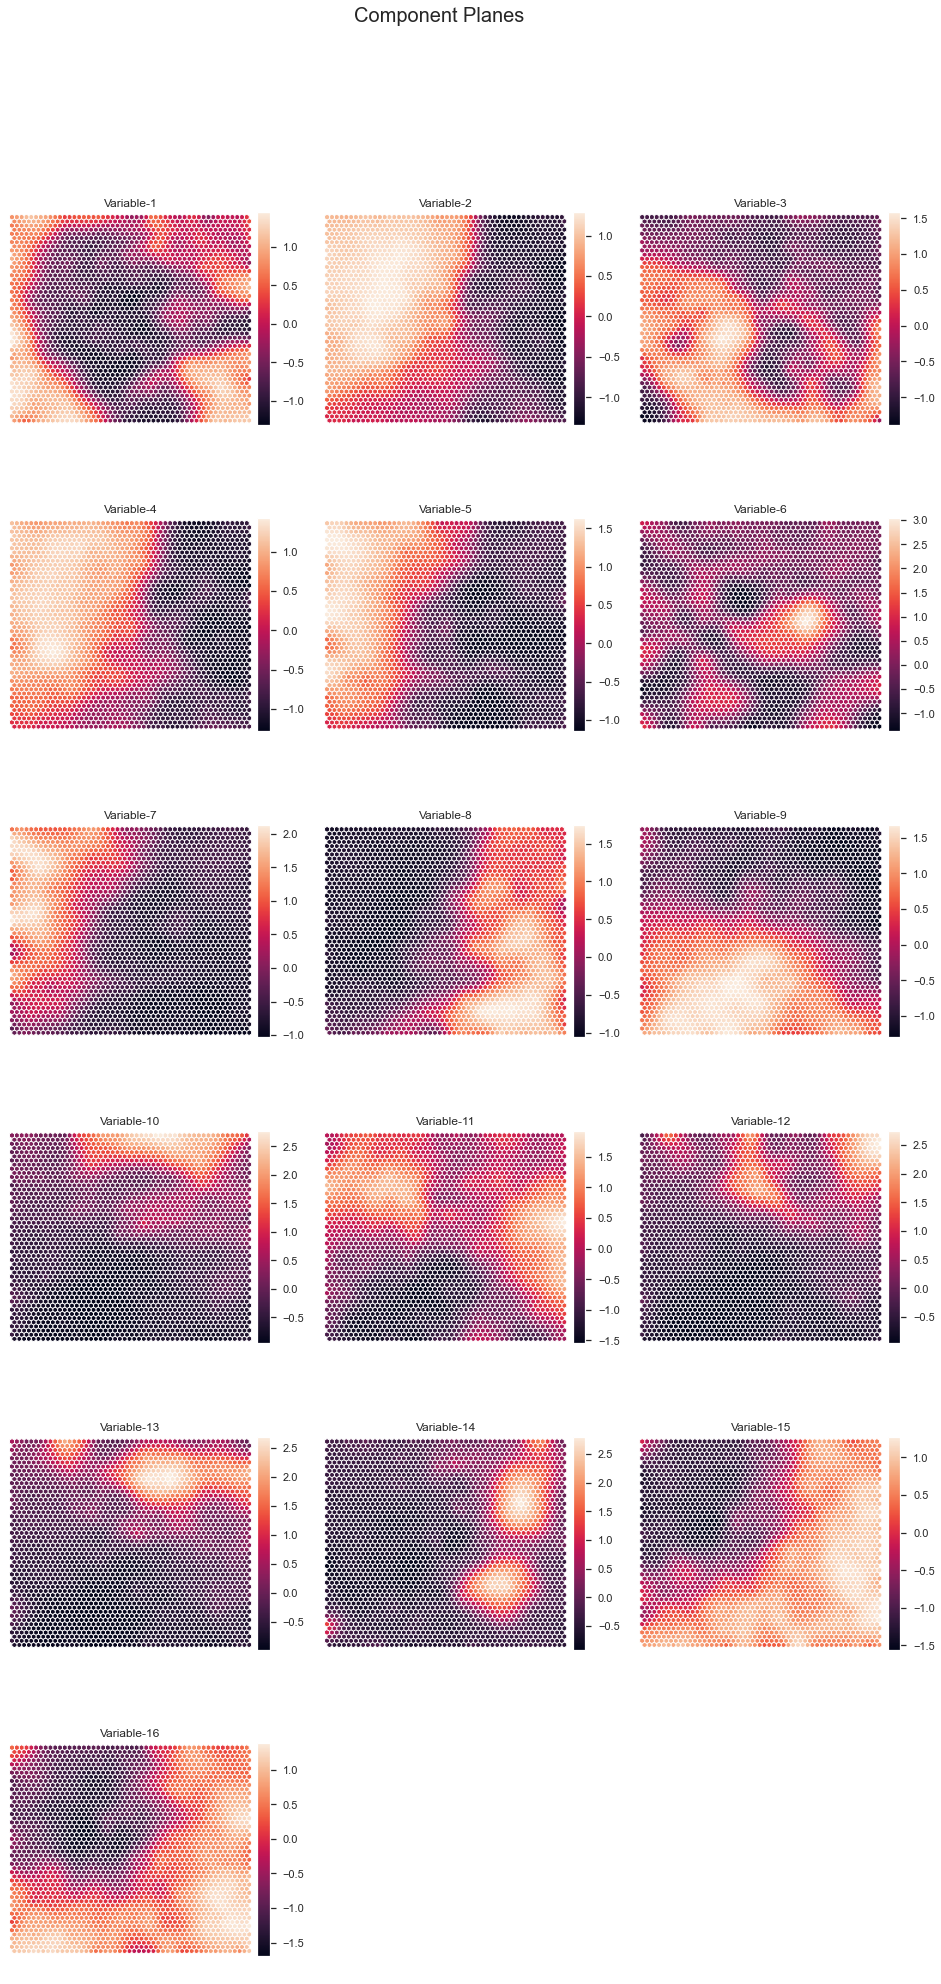

In [113]:
# Component planes on the 50x50 grid
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

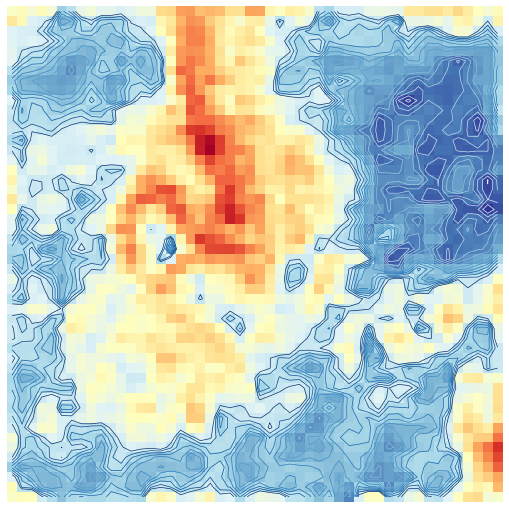

In [114]:
# U-matrix of the 50x50 grid
u = sompy.umatrix.UMatrixView(12, 12, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance2=1, 
    row_normalized=False, 
    show_data=False, 
    contooor=True # Visualize isomorphic curves
)

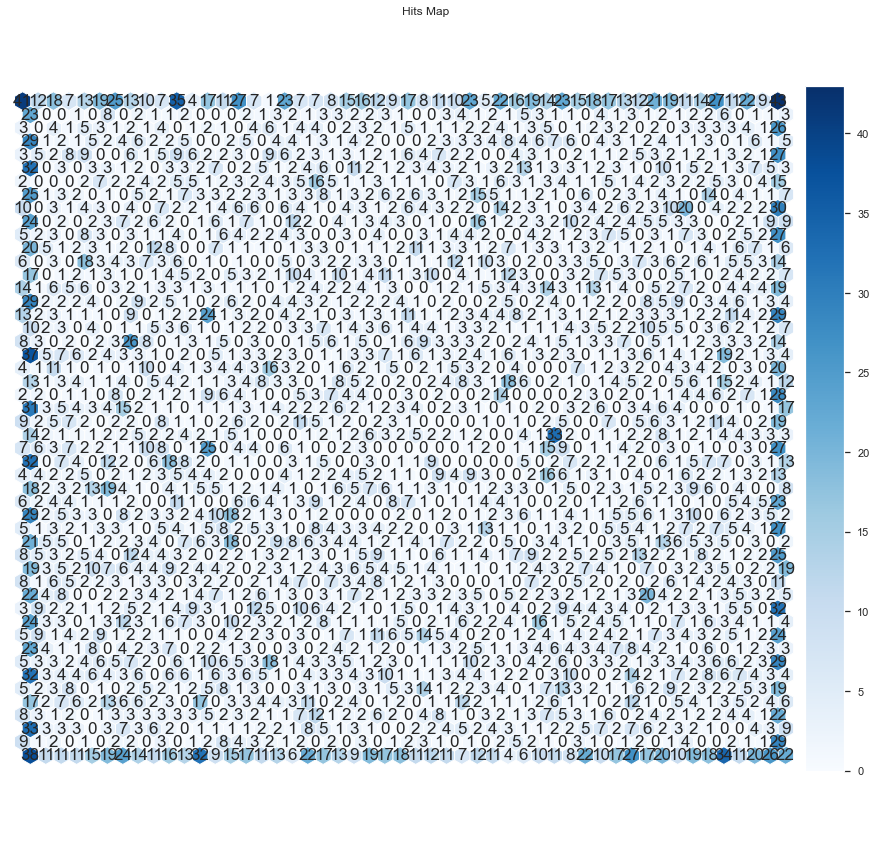

In [115]:
#HIT-MAP
vhts  = BmuHitsView(15,15,"Hits Map")
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=17, cmap="Blues")
plt.show()

### 4.3.2- Number of clusters 


C:\Users\gonca\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\gonca\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\gonca\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\gonca\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, Yellowbrick

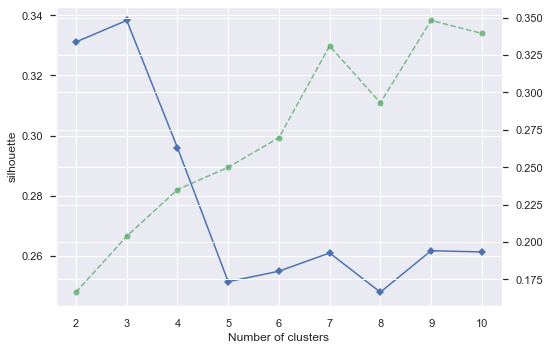

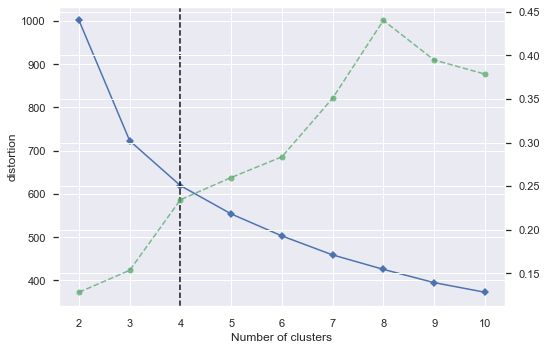

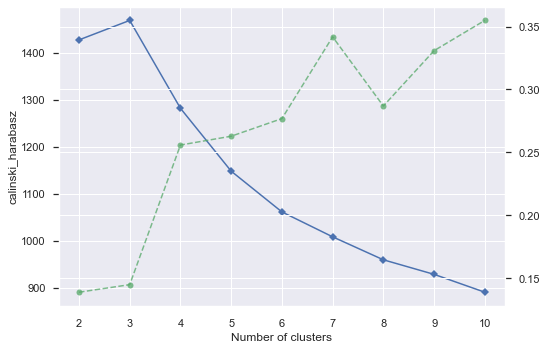

In [116]:
number_clusters(som_units,KMeans( init='k-means++', n_init=15, random_state=1))

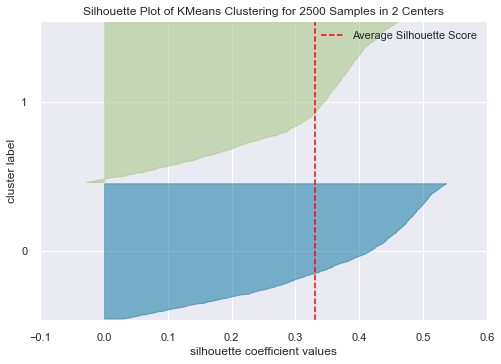

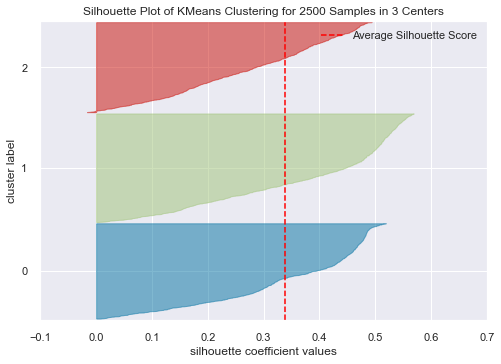

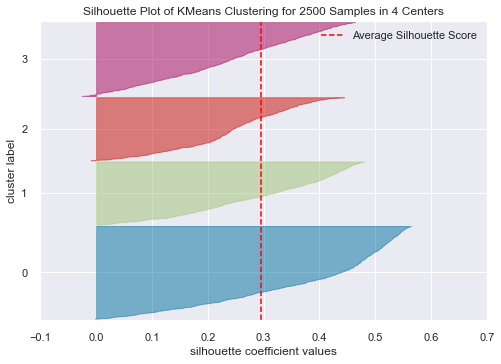

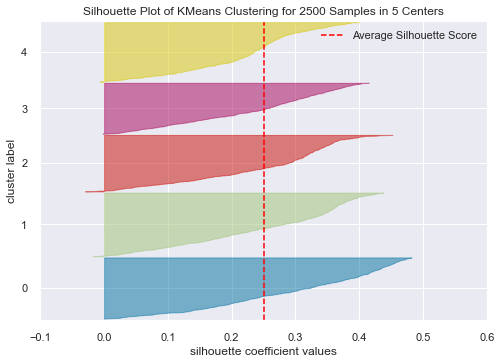

In [117]:
[SilhouetteVisualizer(KMeans(n_clusters=i,init='k-means++', n_init=15, random_state=1), colors='yellowbrick').fit(som_units).show() for i in range(2,6)]

### 4.3.3- Apply the clustering 

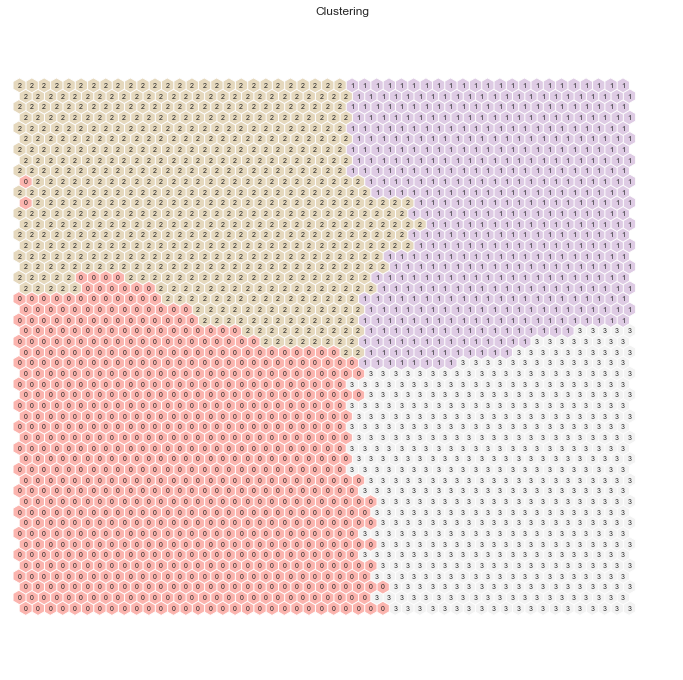

In [118]:
# Perform K-Means clustering on top of the 2500 untis (sm.get_node_vectors() output)
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=20, random_state=42)
nodeclus_labels_KM = sm.cluster(kmeans)

hits  = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [119]:
perspective_nodes_KM = pd.DataFrame(som_units)
perspective_nodes_KM['label'] = nodeclus_labels_KM
perspective_nodes_KM

0         1         2         3         4         5         6  \
0     0.074287 -0.234733 -0.148529 -0.210282 -0.167515 -0.038471 -0.146635   
1     0.013826 -0.247747 -0.171555 -0.218869 -0.165050 -0.027169 -0.138353   
2    -0.017961 -0.250297 -0.180104 -0.223221 -0.168191 -0.016263 -0.134708   
3     0.001087 -0.240514 -0.185773 -0.212812 -0.156990 -0.002775 -0.126681   
4    -0.001385 -0.229430 -0.161171 -0.202012 -0.154019 -0.016249 -0.124352   
...        ...       ...       ...       ...       ...       ...       ...   
2495  0.208449  0.012787 -0.212950  0.040863  0.079743 -0.184840 -0.046315   
2496  0.160892  0.027161 -0.266292  0.051949  0.088625 -0.056409 -0.027973   
2497  0.141608  0.032152 -0.297281  0.053658  0.091470  0.090676 -0.020123   
2498  0.202934  0.028616 -0.326770  0.054721  0.081223  0.187941 -0.047011   
2499  0.238273  0.018399 -0.325404  0.044245  0.066543  0.265913 -0.075499   

             7         8         9        10        11        12        13  \
0     0.126556 -0.230915  0.238423 -0.020175  0.551049 -0.037122  0.016235   
1     0.116474 -0.261896  0.302907 -0.015560  0.550178 -0.009391  0.070180   
2     0.121306 -0.270004  0.323490 -0.006351  0.530119  0.001646  0.173539   
3     0.111768 -0.257326  0.345765 -0.043441  0.499047  0.038778  0.278962   
4     0.110563 -0.241054  0.344478 -0.068580  0.459473  0.074144  0.393446   
...        ...       ...       ...       ...       ...       ...       ...   
2495 -0.114479  0.378055 -0.220199 -0.327535 -0.203788 -0.209590 -0.111743   
2496 -0.135864  0.374132 -0.215135 -0.322912 -0.201317 -0.211612 -0.130645   
2497 -0.147013  0.366313 -0.218193 -0.307010 -0.196036 -0.216827 -0.135514   
2498 -0.124507  0.331473 -0.195769 -0.274448 -0.187292 -0.191753 -0.128126   
2499 -0.092002  0.323609 -0.185339 -0.276722 -0.178890 -0.181152 -0.098476   

            14        15  label  
0     0.129240  0.134473      3  
1     0.121023  0.100606      3  
2     0.115004  0.076987      3  
3     0.101830  0.074478      3  
4     0.083360  0.054998      3  
...        ...       ...    ...  
2495  0.232046  0.321771      2  
2496  0.217802  0.304669      2  
2497  0.197523  0.292134      2  
2498  0.190657  0.286643      2  
2499  0.184835  0.285580      2  

[2500 rows x 17 columns]

In [120]:
# Obtaining SOM's BMUs labels
bmus_map = sm.find_bmu(perspective)[0]  # get bmus for each observation in df

perspective_bmus = pd.DataFrame(
    np.concatenate((perspective, np.expand_dims(bmus_map,1)), axis=1),
    index=perspective.index, columns=np.append(perspective.columns,"BMU")
)
perspective_bmus

Dayswus       Age       Edu    Income      Freq   Recency       LTV  \
0    -0.386685  0.115790  0.551252  0.084099  0.128873 -0.315187  0.245044   
1     0.156308  0.343155  0.144543  0.276990  0.389456 -0.124698  0.242769   
2    -0.151430 -0.238120 -0.342623 -0.209300 -0.123218  0.013431 -0.100270   
3     0.170299 -0.091967 -0.100257 -0.080551 -0.253960 -0.042648 -0.174499   
4    -0.085694 -0.029673 -0.121884 -0.056412 -0.308742 -0.397524 -0.202662   
...        ...       ...       ...       ...       ...       ...       ...   
9567  0.366237  0.153253  0.551514  0.114085  0.102241  0.059961 -0.033271   
9568 -0.434316  0.293128 -0.283801  0.143237  0.068861 -0.062155  0.170344   
9569 -0.188526 -0.246703 -0.354973 -0.154329 -0.139088  0.049187 -0.098339   
9570  0.147930  0.136350 -0.163348  0.325560  0.308848 -0.263414  0.095482   
9571 -0.014429 -0.157318 -0.107477 -0.153980 -0.138354  0.872041 -0.090428   

       Perdeal    Dryred  Sweetred     Drywh   Sweetwh   Dessert    Exotic  \
0    -0.280078  0.216859 -0.120083 -0.066358 -0.204709 -0.254278 -0.285284   
1    -0.236567 -0.022881 -0.205752  0.307861 -0.173830 -0.113453 -0.213417   
2     0.269407 -0.271403  0.398772 -0.152883  0.453084  0.276804  0.256500   
3     0.321304  0.347085 -0.180853 -0.322071 -0.179285 -0.183778  0.545868   
4     0.036889  0.409776 -0.257984 -0.369330 -0.179867 -0.223421  0.206477   
...        ...       ...       ...       ...       ...       ...       ...   
9567 -0.107596  0.369514 -0.293754 -0.218168 -0.248179 -0.254399 -0.092632   
9568 -0.276390 -0.269954  0.206990  0.170061  0.129592  0.231444 -0.049289   
9569 -0.041140 -0.269310  0.320229 -0.201716  0.580836  0.306566  0.207966   
9570 -0.329809  0.190073  0.165111 -0.465200  0.218390 -0.190648 -0.267866   
9571  0.115307 -0.129085  0.118984 -0.024972  0.144323  0.195498  0.136806   

      WebPurchase  WebVisit     BMU  
0       -0.098759 -0.022023  1129.0  
1       -0.261745 -0.110662  2098.0  
2        0.129568  0.159453   719.0  
3        0.214083  0.180518  1866.0  
4        0.320618  0.100053  1968.0  
...           ...       ...     ...  
9567    -0.253431 -0.157993  1499.0  
9568    -0.371943 -0.391863   973.0  
9569     0.119527 -0.009434   921.0  
9570    -0.156738 -0.025933  2148.0  
9571     0.102772  0.070949  1169.0  

[9572 rows x 17 columns]

In [121]:
# Get cluster labels for each observation
perspective_final_KMSOM =perspective_bmus.merge(perspective_nodes_KM['label'], 'left', left_on="BMU", right_index=True)
perspective_final_KMSOM

Dayswus       Age       Edu    Income      Freq   Recency       LTV  \
0    -0.386685  0.115790  0.551252  0.084099  0.128873 -0.315187  0.245044   
1     0.156308  0.343155  0.144543  0.276990  0.389456 -0.124698  0.242769   
2    -0.151430 -0.238120 -0.342623 -0.209300 -0.123218  0.013431 -0.100270   
3     0.170299 -0.091967 -0.100257 -0.080551 -0.253960 -0.042648 -0.174499   
4    -0.085694 -0.029673 -0.121884 -0.056412 -0.308742 -0.397524 -0.202662   
...        ...       ...       ...       ...       ...       ...       ...   
9567  0.366237  0.153253  0.551514  0.114085  0.102241  0.059961 -0.033271   
9568 -0.434316  0.293128 -0.283801  0.143237  0.068861 -0.062155  0.170344   
9569 -0.188526 -0.246703 -0.354973 -0.154329 -0.139088  0.049187 -0.098339   
9570  0.147930  0.136350 -0.163348  0.325560  0.308848 -0.263414  0.095482   
9571 -0.014429 -0.157318 -0.107477 -0.153980 -0.138354  0.872041 -0.090428   

       Perdeal    Dryred  Sweetred     Drywh   Sweetwh   Dessert    Exotic  \
0    -0.280078  0.216859 -0.120083 -0.066358 -0.204709 -0.254278 -0.285284   
1    -0.236567 -0.022881 -0.205752  0.307861 -0.173830 -0.113453 -0.213417   
2     0.269407 -0.271403  0.398772 -0.152883  0.453084  0.276804  0.256500   
3     0.321304  0.347085 -0.180853 -0.322071 -0.179285 -0.183778  0.545868   
4     0.036889  0.409776 -0.257984 -0.369330 -0.179867 -0.223421  0.206477   
...        ...       ...       ...       ...       ...       ...       ...   
9567 -0.107596  0.369514 -0.293754 -0.218168 -0.248179 -0.254399 -0.092632   
9568 -0.276390 -0.269954  0.206990  0.170061  0.129592  0.231444 -0.049289   
9569 -0.041140 -0.269310  0.320229 -0.201716  0.580836  0.306566  0.207966   
9570 -0.329809  0.190073  0.165111 -0.465200  0.218390 -0.190648 -0.267866   
9571  0.115307 -0.129085  0.118984 -0.024972  0.144323  0.195498  0.136806   

      WebPurchase  WebVisit     BMU  label  
0       -0.098759 -0.022023  1129.0      0  
1       -0.261745 -0.110662  2098.0      2  
2        0.129568  0.159453   719.0      3  
3        0.214083  0.180518  1866.0      1  
4        0.320618  0.100053  1968.0      1  
...           ...       ...     ...    ...  
9567    -0.253431 -0.157993  1499.0      0  
9568    -0.371943 -0.391863   973.0      0  
9569     0.119527 -0.009434   921.0      3  
9570    -0.156738 -0.025933  2148.0      2  
9571     0.102772  0.070949  1169.0      1  

[9572 rows x 18 columns]

In [122]:
# Characterizing the final clusters
perspective_final_KMSOM.drop(columns='BMU').groupby('label').mean()

Dayswus       Age       Edu    Income      Freq   Recency       LTV  \
label                                                                         
0     -0.101579  0.243585  0.026031  0.222486  0.172220 -0.047925  0.164276   
1      0.010434 -0.209385  0.053471 -0.204495 -0.223714  0.071551 -0.203259   
2      0.073237  0.121240  0.042116  0.124622  0.115567 -0.016540  0.056443   
3     -0.021094 -0.226975 -0.156586 -0.216445 -0.175698 -0.065826 -0.146123   

        Perdeal    Dryred  Sweetred     Drywh   Sweetwh   Dessert    Exotic  \
label                                                                         
0     -0.216787 -0.086563  0.040084  0.108381  0.028753  0.017876 -0.115065   
1      0.243044  0.051550 -0.069183  0.039033 -0.081947 -0.081983  0.030460   
2     -0.136677  0.237807 -0.141352 -0.196463 -0.139609 -0.135044 -0.090329   
3      0.146382 -0.239704  0.189554  0.057748  0.230907  0.246189  0.196591   

       WebPurchase  WebVisit  
label                         
0        -0.265254 -0.285951  
1         0.207611  0.188674  
2        -0.018087  0.034378  
3         0.116764  0.077490

### 4.3.4- Cluster Profiles

TypeError: annotate() missing 1 required positional argument: 's'

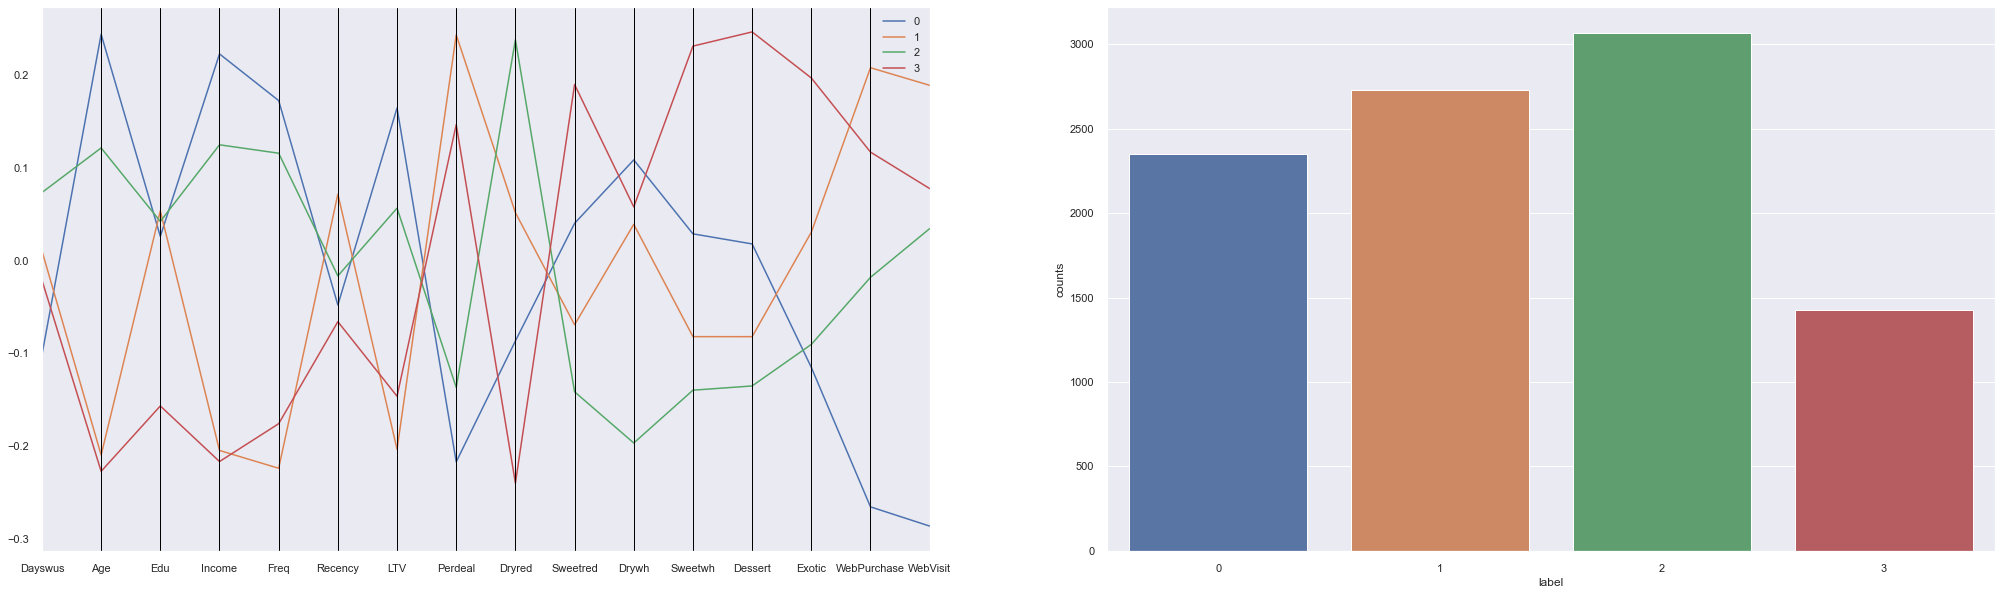

In [123]:
cluster_profiles(perspective_final_KMSOM.drop('BMU',axis=1), ["label"], (35,10), compar_titles=None)

## 4.4- Hierarchical Clustering on top of SOM units
### 4.4.1- R2 plot

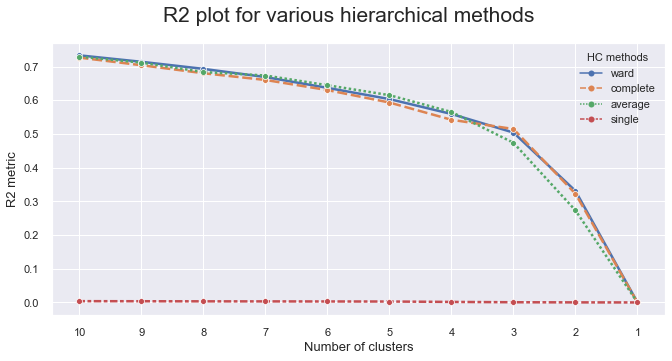

In [124]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack([get_r2_hc(df=pd.DataFrame(som_units), link_method=link, max_nclus=max_nclus) for link in hc_methods]).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

### 4.4.2- Dendrogram

In [125]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(pd.DataFrame(som_units))

array([2068, 2072, 2217, ...,    1,    2,    0], dtype=int64)

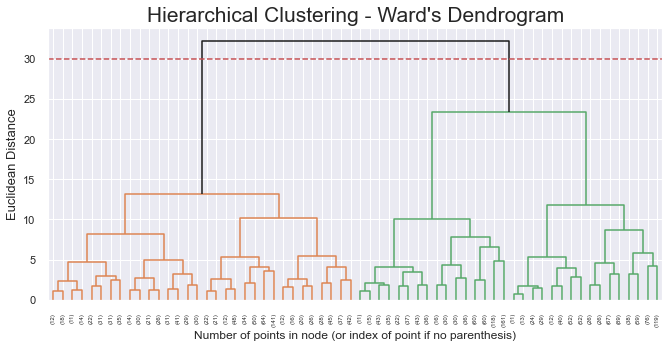

In [126]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# setting the threshold
y_threshold = 30
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

### 4.4.3- Number of clusters

C:\Users\gonca\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\gonca\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\gonca\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\gonca\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, Yellowbrick

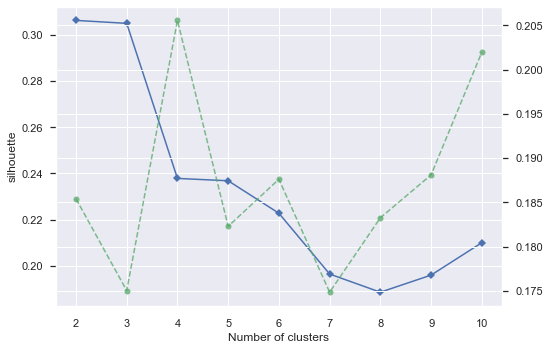

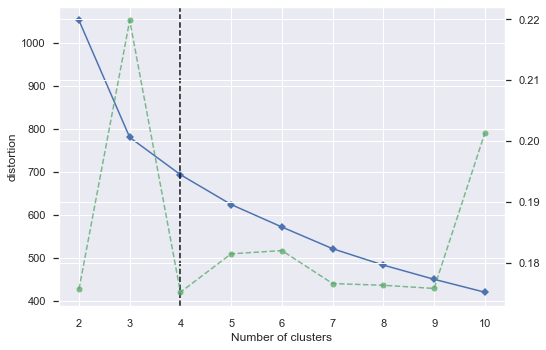

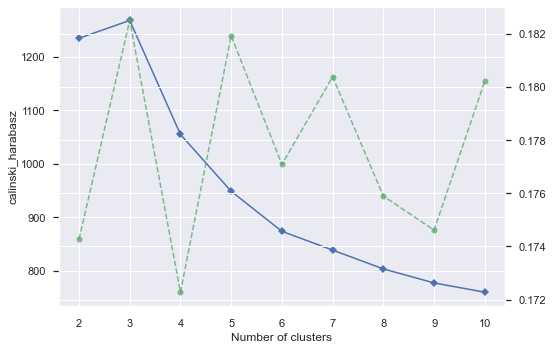

In [127]:
number_clusters(som_units, AgglomerativeClustering(linkage=linkage))

### 4.4.4- Applying the Clustering

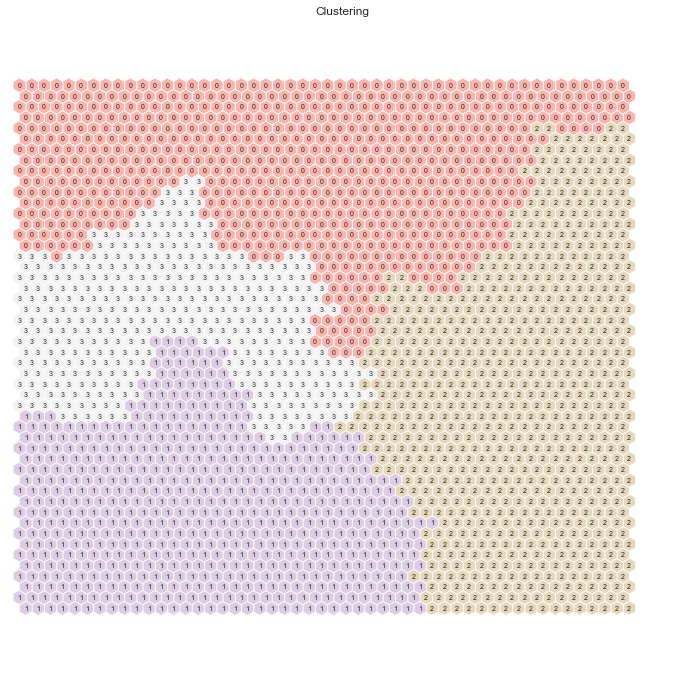

In [128]:
# Perform Hierarchical clustering on top of the 2500 untis (sm.get_node_vectors() output)
hierclust = AgglomerativeClustering(n_clusters=4, linkage='ward')
nodeclus_labels_HC= sm.cluster(hierclust)

hits  = HitMapView(12, 12,"Clustering",text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [129]:
# Check the nodes and and respective clusters
nodes = sm.get_node_vectors()

perspective_nodes_HC = pd.DataFrame(nodes)
perspective_nodes_HC['label'] = nodeclus_labels_HC
perspective_nodes_HC

0         1         2         3         4         5         6  \
0     0.074287 -0.234733 -0.148529 -0.210282 -0.167515 -0.038471 -0.146635   
1     0.013826 -0.247747 -0.171555 -0.218869 -0.165050 -0.027169 -0.138353   
2    -0.017961 -0.250297 -0.180104 -0.223221 -0.168191 -0.016263 -0.134708   
3     0.001087 -0.240514 -0.185773 -0.212812 -0.156990 -0.002775 -0.126681   
4    -0.001385 -0.229430 -0.161171 -0.202012 -0.154019 -0.016249 -0.124352   
...        ...       ...       ...       ...       ...       ...       ...   
2495  0.208449  0.012787 -0.212950  0.040863  0.079743 -0.184840 -0.046315   
2496  0.160892  0.027161 -0.266292  0.051949  0.088625 -0.056409 -0.027973   
2497  0.141608  0.032152 -0.297281  0.053658  0.091470  0.090676 -0.020123   
2498  0.202934  0.028616 -0.326770  0.054721  0.081223  0.187941 -0.047011   
2499  0.238273  0.018399 -0.325404  0.044245  0.066543  0.265913 -0.075499   

             7         8         9        10        11        12        13  \
0     0.126556 -0.230915  0.238423 -0.020175  0.551049 -0.037122  0.016235   
1     0.116474 -0.261896  0.302907 -0.015560  0.550178 -0.009391  0.070180   
2     0.121306 -0.270004  0.323490 -0.006351  0.530119  0.001646  0.173539   
3     0.111768 -0.257326  0.345765 -0.043441  0.499047  0.038778  0.278962   
4     0.110563 -0.241054  0.344478 -0.068580  0.459473  0.074144  0.393446   
...        ...       ...       ...       ...       ...       ...       ...   
2495 -0.114479  0.378055 -0.220199 -0.327535 -0.203788 -0.209590 -0.111743   
2496 -0.135864  0.374132 -0.215135 -0.322912 -0.201317 -0.211612 -0.130645   
2497 -0.147013  0.366313 -0.218193 -0.307010 -0.196036 -0.216827 -0.135514   
2498 -0.124507  0.331473 -0.195769 -0.274448 -0.187292 -0.191753 -0.128126   
2499 -0.092002  0.323609 -0.185339 -0.276722 -0.178890 -0.181152 -0.098476   

            14        15  label  
0     0.129240  0.134473      2  
1     0.121023  0.100606      2  
2     0.115004  0.076987      2  
3     0.101830  0.074478      2  
4     0.083360  0.054998      2  
...        ...       ...    ...  
2495  0.232046  0.321771      0  
2496  0.217802  0.304669      0  
2497  0.197523  0.292134      0  
2498  0.190657  0.286643      0  
2499  0.184835  0.285580      0  

[2500 rows x 17 columns]

In [130]:
# Obtaining SOM's BMUs labels
bmus_map = sm.find_bmu(perspective)[0]  # get bmus for each observation in df

perspective_bmus = pd.DataFrame(
    np.concatenate((perspective, np.expand_dims(bmus_map,1)), axis=1),
    index=perspective.index, columns=np.append(perspective.columns,"BMU")
)
perspective_bmus

Dayswus       Age       Edu    Income      Freq   Recency       LTV  \
0    -0.386685  0.115790  0.551252  0.084099  0.128873 -0.315187  0.245044   
1     0.156308  0.343155  0.144543  0.276990  0.389456 -0.124698  0.242769   
2    -0.151430 -0.238120 -0.342623 -0.209300 -0.123218  0.013431 -0.100270   
3     0.170299 -0.091967 -0.100257 -0.080551 -0.253960 -0.042648 -0.174499   
4    -0.085694 -0.029673 -0.121884 -0.056412 -0.308742 -0.397524 -0.202662   
...        ...       ...       ...       ...       ...       ...       ...   
9567  0.366237  0.153253  0.551514  0.114085  0.102241  0.059961 -0.033271   
9568 -0.434316  0.293128 -0.283801  0.143237  0.068861 -0.062155  0.170344   
9569 -0.188526 -0.246703 -0.354973 -0.154329 -0.139088  0.049187 -0.098339   
9570  0.147930  0.136350 -0.163348  0.325560  0.308848 -0.263414  0.095482   
9571 -0.014429 -0.157318 -0.107477 -0.153980 -0.138354  0.872041 -0.090428   

       Perdeal    Dryred  Sweetred     Drywh   Sweetwh   Dessert    Exotic  \
0    -0.280078  0.216859 -0.120083 -0.066358 -0.204709 -0.254278 -0.285284   
1    -0.236567 -0.022881 -0.205752  0.307861 -0.173830 -0.113453 -0.213417   
2     0.269407 -0.271403  0.398772 -0.152883  0.453084  0.276804  0.256500   
3     0.321304  0.347085 -0.180853 -0.322071 -0.179285 -0.183778  0.545868   
4     0.036889  0.409776 -0.257984 -0.369330 -0.179867 -0.223421  0.206477   
...        ...       ...       ...       ...       ...       ...       ...   
9567 -0.107596  0.369514 -0.293754 -0.218168 -0.248179 -0.254399 -0.092632   
9568 -0.276390 -0.269954  0.206990  0.170061  0.129592  0.231444 -0.049289   
9569 -0.041140 -0.269310  0.320229 -0.201716  0.580836  0.306566  0.207966   
9570 -0.329809  0.190073  0.165111 -0.465200  0.218390 -0.190648 -0.267866   
9571  0.115307 -0.129085  0.118984 -0.024972  0.144323  0.195498  0.136806   

      WebPurchase  WebVisit     BMU  
0       -0.098759 -0.022023  1129.0  
1       -0.261745 -0.110662  2098.0  
2        0.129568  0.159453   719.0  
3        0.214083  0.180518  1866.0  
4        0.320618  0.100053  1968.0  
...           ...       ...     ...  
9567    -0.253431 -0.157993  1499.0  
9568    -0.371943 -0.391863   973.0  
9569     0.119527 -0.009434   921.0  
9570    -0.156738 -0.025933  2148.0  
9571     0.102772  0.070949  1169.0  

[9572 rows x 17 columns]

In [131]:
# Get cluster labels for each observation
perspective_final_HC = perspective_bmus.merge(perspective_nodes_HC['label'], 'left', left_on="BMU", right_index=True)
perspective_final_HC_r2 = perspective_final_HC.copy()
perspective_final_HC

Dayswus       Age       Edu    Income      Freq   Recency       LTV  \
0    -0.386685  0.115790  0.551252  0.084099  0.128873 -0.315187  0.245044   
1     0.156308  0.343155  0.144543  0.276990  0.389456 -0.124698  0.242769   
2    -0.151430 -0.238120 -0.342623 -0.209300 -0.123218  0.013431 -0.100270   
3     0.170299 -0.091967 -0.100257 -0.080551 -0.253960 -0.042648 -0.174499   
4    -0.085694 -0.029673 -0.121884 -0.056412 -0.308742 -0.397524 -0.202662   
...        ...       ...       ...       ...       ...       ...       ...   
9567  0.366237  0.153253  0.551514  0.114085  0.102241  0.059961 -0.033271   
9568 -0.434316  0.293128 -0.283801  0.143237  0.068861 -0.062155  0.170344   
9569 -0.188526 -0.246703 -0.354973 -0.154329 -0.139088  0.049187 -0.098339   
9570  0.147930  0.136350 -0.163348  0.325560  0.308848 -0.263414  0.095482   
9571 -0.014429 -0.157318 -0.107477 -0.153980 -0.138354  0.872041 -0.090428   

       Perdeal    Dryred  Sweetred     Drywh   Sweetwh   Dessert    Exotic  \
0    -0.280078  0.216859 -0.120083 -0.066358 -0.204709 -0.254278 -0.285284   
1    -0.236567 -0.022881 -0.205752  0.307861 -0.173830 -0.113453 -0.213417   
2     0.269407 -0.271403  0.398772 -0.152883  0.453084  0.276804  0.256500   
3     0.321304  0.347085 -0.180853 -0.322071 -0.179285 -0.183778  0.545868   
4     0.036889  0.409776 -0.257984 -0.369330 -0.179867 -0.223421  0.206477   
...        ...       ...       ...       ...       ...       ...       ...   
9567 -0.107596  0.369514 -0.293754 -0.218168 -0.248179 -0.254399 -0.092632   
9568 -0.276390 -0.269954  0.206990  0.170061  0.129592  0.231444 -0.049289   
9569 -0.041140 -0.269310  0.320229 -0.201716  0.580836  0.306566  0.207966   
9570 -0.329809  0.190073  0.165111 -0.465200  0.218390 -0.190648 -0.267866   
9571  0.115307 -0.129085  0.118984 -0.024972  0.144323  0.195498  0.136806   

      WebPurchase  WebVisit     BMU  label  
0       -0.098759 -0.022023  1129.0      3  
1       -0.261745 -0.110662  2098.0      0  
2        0.129568  0.159453   719.0      2  
3        0.214083  0.180518  1866.0      0  
4        0.320618  0.100053  1968.0      0  
...           ...       ...     ...    ...  
9567    -0.253431 -0.157993  1499.0      3  
9568    -0.371943 -0.391863   973.0      3  
9569     0.119527 -0.009434   921.0      2  
9570    -0.156738 -0.025933  2148.0      0  
9571     0.102772  0.070949  1169.0      2  

[9572 rows x 18 columns]

In [132]:
# Characterizing the final clusters
perspective_final_HC.drop(columns='BMU').groupby('label').mean()

Dayswus       Age       Edu    Income      Freq   Recency       LTV  \
label                                                                         
0      0.054641  0.051318  0.028797  0.053212  0.029250 -0.047035 -0.016730   
1      0.045830  0.198484 -0.188018  0.195167  0.193969 -0.024847  0.191161   
2      0.006902 -0.236235 -0.033058 -0.226877 -0.204541  0.072000 -0.174236   
3     -0.108392  0.210813  0.073562  0.191864  0.142502 -0.040352  0.133724   

        Perdeal    Dryred  Sweetred     Drywh   Sweetwh   Dessert    Exotic  \
label                                                                         
0     -0.034690  0.237611 -0.148359 -0.185228 -0.144357 -0.142327 -0.051161   
1     -0.193224 -0.182448  0.150909  0.027751  0.263730  0.116400 -0.057518   
2      0.197602 -0.117036  0.060622  0.092068  0.074786  0.077862  0.100911   
3     -0.191581 -0.059233  0.024143  0.102271 -0.016673  0.003554 -0.116441   

       WebPurchase  WebVisit  
label                         
0         0.042794  0.077891  
1        -0.178989 -0.153762  
2         0.178517  0.152215  
3        -0.244663 -0.268205

### 4.4.5- Cluster Profiles

TypeError: annotate() missing 1 required positional argument: 's'

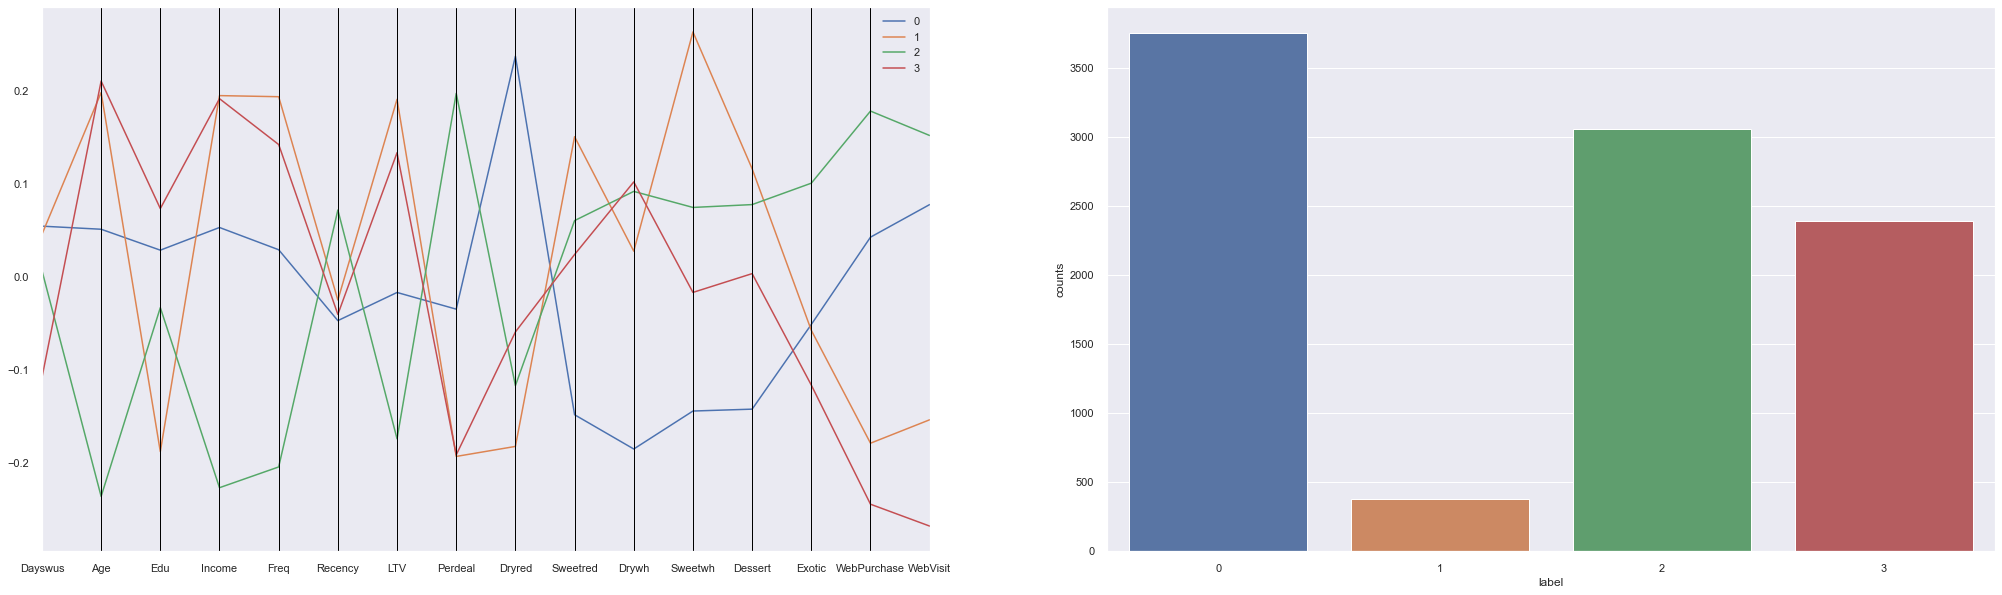

In [133]:
cluster_profiles(perspective_final_HC.drop('BMU',axis=1), ["label"], (35,10), compar_titles=None)

# 5 - Comparing each clustering method

To compare the diferrent clustering methods we decid to use the R2 as a metric evaluation of each method

In [ ]:
def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst

In [87]:
print('The r2 of the k-means method is', r2(km_perspective, 'km_labels').round(2))
print('The r2 of the GMM method is', r2(gmm_perspective, 'gmm_labels').round(2))
print('The r2 of the k-means + SOM method is', r2(perspective_final_KMSOM, 'label').round(2))
print('The r2 of the HC + Som method is', r2(perspective_final_HC_r2, 'label').round(2))                                      


The r2 of the k-means method is 0.94
The r2 of the GMM method is 0.93
The r2 of the k-means + SOM method is 0.71
The r2 of the HC + Som method is 0.38
